In [23]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [24]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [25]:
len(traindataset) // 32
    

419

In [26]:
# Let's quickly get a glimpse into the data
humorcount = 0
reuterscount = 0
wikicount = 0
proverbcount = 0
for x, y in traindataset:
    
    if y == "humor": 
        humorcount = humorcount + 1
    if y =="reuters":
        reuterscount = reuterscount + 1
    if y =="wiki": 
        wikicount = wikicount + 1
    if y =="proverbs":
        proverbcount = proverbcount + 1
print('humorcount ' + str(humorcount) +
       ' reuterscount ' + str(reuterscount) +
       ' wikicount ' + str(wikicount) +
       ' proverbcount ' + str(proverbcount))


# it seems we do not have a lot of proverbs


humorcount 4213 reuterscount 4186 wikicount 4181 proverbcount 831


In [27]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [28]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-27 09:07:00.632 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [29]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [30]:
# TODO ~ about 4 lines of code
print('Chance to guess humor correctly:' + str(humorcount / len(traindataset)))
print('Chance to guess reuters correctly:' + str(reuterscount / len(traindataset)))
print('Chance to guess wiki correctly:' + str(wikicount / len(traindataset)))
print('Chance to guess proverb correctly:' + str(proverbcount / len(traindataset)))

# As we already saw during the short data inspection is that there is a data imbalance. Hence the low score on a blind prediction. 
# This means, depending on the model and setting swe use we might run into bad performance for especially the proverbs.
# We will go into the techniques to combat this deeper in Question 5

Chance to guess humor correctly:0.31414510476474533
Chance to guess reuters correctly:0.3121318320781448
Chance to guess wiki correctly:0.31175900380284843
Chance to guess proverb correctly:0.06196405935426143


Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [31]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]
    pass


To test the preprocessor:

In [32]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [33]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [43]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 43]),
 tensor([2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1,
         0, 0, 2, 2, 3, 1, 2, 0]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [35]:
from src.models import metrics
from src.models.metrics import Metric
from sklearn.metrics import accuracy_score
import torch

In [36]:
# custome metric using accuracy score
Tensor = torch.Tensor
class CustomMetric(Metric):
    """
    Simple metric using accuracy score 
    """
    def __repr__(self) -> str:
        return "CustomMetric"

    def __call__(self, y: Tensor, yhat: Tensor) -> Tensor:
        yhat = yhat.argmax(dim=1)
        score = accuracy_score(y, yhat, normalize=True)
        return torch.tensor(score)

In [37]:

import torch
# TODO ~ 2 lines of code

metrics = metrics.F1Score() 
#metrics = CustomMetric() 
# The custom metric didn't do all that bad, but was outperformed by the F1 metric 
# See confusion matrix in figures

loss_fn = torch.nn.CrossEntropyLoss() # Used for multiclass classification


## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [44]:
# We start of with using a fairly simple NLP model 
# A more interesting model can be found in our TRAX based Tuned model in Question 6, including train loop and logging
log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
from src.models import rnn

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.1,
    "output_size": 4,
}
# load the model
model = rnn.NLPmodel(config)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [46]:
dslen = len(traindataset)
print ("We can get " + str(int(dslen / 32)) + ' batches')
print ("with 25 trainsteps which each take a batch of 32 items from the traindataset we get " + 
        str(25 * 32) + " items from the dataset which has " + str(dslen) + " items")
print ("This means we need to run for " + str(int(dslen / (25 * 32)) + 1) + " epochs to cover all data"  )
print ("We chose 25 as a reasonable amount to start with and observe how the performance evolves.") 
# Note on the 25 although we increased this amount later on as the model kept learning a bit. 
# The optimum amount of epochs seems to be around 50 (where the test loss was lowest). 
# Maybe a callback function to stop like (https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/) is a good option here


We can get 419 batches
with 25 trainsteps which each take a batch of 32 items from the traindataset we get 800 items from the dataset which has 13411 items
This means we need to run for 17 epochs to cover all data
We chose 25 as a reasonable amount to start with and observe how the performance evolves.


In [40]:
from src.training import train_model

model = train_model.trainloop(
    epochs=100,
    model=model,
    metrics=[metrics],
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-06-27 09:07:02.225 | INFO     | src.data.data_tools:dir_add_timestamp:78 - Logging to ../tune/20220627-0907
100%|██████████| 25/25 [00:01<00:00, 18.12it/s]
2022-06-27 09:07:03.885 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2991 test 1.2458 metric ['0.2684']
100%|██████████| 25/25 [00:01<00:00, 21.55it/s]
2022-06-27 09:07:05.383 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2523 test 1.2104 metric ['0.3262']
100%|██████████| 25/25 [00:01<00:00, 21.67it/s]
2022-06-27 09:07:06.789 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 1.1963 test 1.0965 metric ['0.3342']
100%|██████████| 25/25 [00:01<00:00, 22.67it/s]
2022-06-27 09:07:08.148 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 1.0616 test 0.9573 metric ['0.4160']
100%|██████████| 25/25 [00:01<00:00, 22.76it/s]
2022-06-27 09:07:09.530 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train 0.9097 test 0.8894 metric ['0.4557']
10

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

your explanation here

<b>Initially testing with 25 epochs both the train and test loss kept going down, so I increased the epochs to 50.

Here after about 50 epochs the train loss still went down but the test loss went up and down, showing there was overfitting going on. 
The training loop scheduler decreased the learning rate when it plateaud, and initially got some better results, but test results got worse again untill the learning rate was lowered again.

After running for 100 epochs we can see the test loss steadily increasing which might indicate the learning model is not picking up structures, but remembering data. </b>

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

In [41]:
y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]


[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

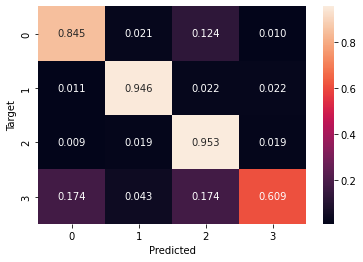

In [42]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

<b>The classes are : "humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3

Q1 : It seems the model has some difficulty understanding both humor and proverbs.
Both seem to be mistaken for wiki entries. 
The bad performance for the proverbs is likely because of the low amount of proverbs in the dataset. Detecting whether a text is a joke or not is apparently already challenging :
(https://hdsr.mitpress.mit.edu/pub/wi9yky5c/release/3)
We might try to use a Bert like model to detect this like the paper suggests "BERT-like models vastly outperform other approaches in humor detection ; .".

Q2 : Seeing the dataset in unbalanced (we only have 800 proverbs) the F1 score will be a better metric.

Q3 : Question 1 answers the question about the balance of the data. This unbalanced data is the reason why we chose a F1 metric after our custom metric and it provides much better results for proverbs. I've added a screenshot of the confusion metric in the figures directory.

Q4 : We can try to either find more proverbs. We can also use oversampling on the proverb class or using less items from the other classes (undersample). 
 .


# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

In [ ]:
# A new trax model with a trax training loop, config saving etc. can be found in 02_style detection_custom.ipynb
